In [1]:
RASPBERRY_PI = False
if RASPBERRY_PI:
    !pip install .
else:        
    !pip install git+https://github.com/madhuhegde/super_resolution.git

  Cloning https://github.com/madhuhegde/super_resolution.git to /private/var/folders/2h/l5d7t83505v2q98ksvtcld1m0000gn/T/pip-req-build-udjdacak
  Running command git clone --filter=blob:none --quiet https://github.com/madhuhegde/super_resolution.git /private/var/folders/2h/l5d7t83505v2q98ksvtcld1m0000gn/T/pip-req-build-udjdacak
  Resolved https://github.com/madhuhegde/super_resolution.git to commit 03b35f14fbd24e6fee1da2a6734dc01b66fee0de
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [26]:
from latent_diffusion import LDMSuperResolutionPipeline
from latent_diffusion import LDMConsistencySRPipeline
import torch

# load model 
pipeline = LDMSuperResolutionPipeline() 

device = "cuda" if torch.cuda.is_available() else "cpu"
pipeline.unet.to(device)
pipeline.vaedecoder.to(device)

#set device
if RASPBERRY_PI:
   device = "cpu" #"cuda" if torch.cuda.is_available() else "cpu"
   PATH_UNET = "/home/raspberry/work/diffusion/Unet_model_dict.pt"  
   PATH_VAE_DECODER = "/home/raspberry/work/diffusion/vae_decoder_model.pt" 
   pipeline.unet.load_state_dict(torch.load(PATH_UNET)) #, map_location=torch.device('cpu'))) 
   pipeline.vaedecoder.load_state_dict(torch.load(PATH_VAE_DECODER)) 
else:
   #PATH_VQVAE = "/Users/madhuhegde/work/diffusion/LDM/hf_vqvae_model.pt" #"VQ_model_dict.pt"
   PATH_UNET = "/Users/madhuhegde/work/diffusion/LDM/hf_unet_fp16_model.pt" 
   PATH_VAE_DECODER = "/Users/madhuhegde/work/diffusion/LDM/vae_decoder_fp16_model.pt" 
   device = "cuda" if torch.cuda.is_available() else "cpu" 
   #pipeline.vqvae.load_state_dict(torch.load(PATH_VQVAE)) 
   pipeline.unet.load_state_dict(torch.load(PATH_UNET, map_location=torch.device('cpu')))
   pipeline.vaedecoder.load_state_dict(torch.load(PATH_VAE_DECODER))  

pipeline.unet.float()
pipeline.vaedecoder.float()

sample_size=64, in_channels=6,out_channels=3, center_input_sample=False,time_embedding_type=positional,freq_shift=0,flip_sin_to_cos=True
down_block_types=['DownBlock2D', 'DownBlock2D', 'DownBlock2D', 'AttnDownBlock2D'],up_block_types=['AttnUpBlock2D', 'UpBlock2D', 'UpBlock2D', 'UpBlock2D'], block_out_channels=[160, 320, 320, 640],layers_per_block=2,mid_block_scale_factor=1,downsample_padding=1,downsample_type=conv,upsample_type=conv,dropout=0.0,act_fn=silu
attention_head_dim=32,norm_num_groups=32,attn_norm_num_groups=None,norm_eps=1e-05,resnet_time_scale_shift=default,add_attention=True,class_embed_type=None,num_class_embeds=None,num_train_timesteps=None
in_channels=3,out_channels=3,up_block_types=['UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D'], block_out_channels=[128, 256, 512], layers_per_block=2, act_fn=silu,latent_channels=3
latent_channels=3, sample_size=256,num_vq_embeddings=8192, norm_num_groups=32, vq_embed_dim =3,scaling_factor=0.18215,norm_type=group


VAEDecoder(
  (quant_conv): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (quantize): VectorQuantizer(
    (embedding): Embedding(8192, 3)
  )
  (post_quant_conv): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (decoder): Decoder(
    (conv_in): Conv2d(3, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (up_blocks): ModuleList(
      (0): UpDecoderBlock2D(
        (resnets): ModuleList(
          (0-2): 3 x ResnetBlock2D(
            (norm1): GroupNorm(32, 512, eps=1e-06, affine=True)
            (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 512, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (upsamplers): ModuleList(
          (0): Upsample2D(
            (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding

In [11]:

from PIL import Image
if RASPBERRY_PI:
  image  = Image.open("/home/raspberry/Downloads/kairu.jpg").convert("RGB")
  image = image.crop((0, 40, 463, 503))
  down_size_img = image.resize((96, 96))  
else: 
  image  = Image.open("/Users/madhuhegde/work/diffusion/LDM/kairu.png").convert("RGB")  
  down_size_img = image.resize((128, 128))

In [27]:
# DDPM Sampling with eta = 0.1


# run pipeline in inference (sample random noise and denoise)
super_res_image = pipeline(down_size_img, num_inference_steps=20, eta=0.1).images[0]
del pipeline

100%|███████████████████████████████████████████| 20/20 [00:24<00:00,  1.23s/it]


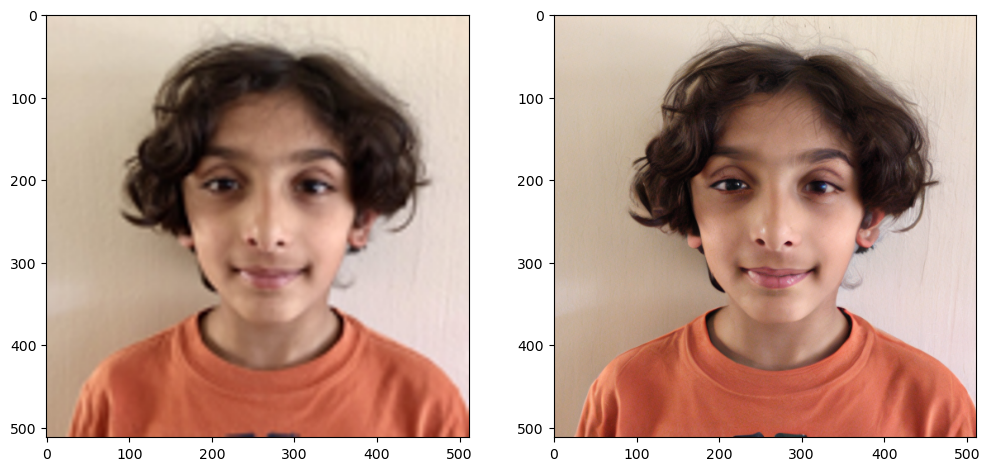

In [28]:
import matplotlib.pyplot as plt
if RASPBERRY_PI:
   low_res_img = down_size_img.resize((96*4, 96*4))
else:    
   low_res_img = down_size_img.resize((128*4, 128*4))
f, axarr = plt.subplots(1,2, figsize=(12, 12))
axarr[0].imshow(low_res_img )
axarr[1].imshow(super_res_image )

In [29]:
pipeline = LDMConsistencySRPipeline()

pipeline.vaedecoder.to(device)

pipeline.unet.to(device)

in_channels=3,out_channels=3,up_block_types=['UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D'], block_out_channels=[128, 256, 512], layers_per_block=2, act_fn=silu,latent_channels=3
latent_channels=3, sample_size=256,num_vq_embeddings=8192, norm_num_groups=32, vq_embed_dim =3,scaling_factor=0.18215,norm_type=group
sample_size=64, in_channels=6,out_channels=3, center_input_sample=False,time_embedding_type=positional,freq_shift=0,flip_sin_to_cos=True
down_block_types=['DownBlock2D', 'DownBlock2D', 'DownBlock2D', 'AttnDownBlock2D'],up_block_types=['AttnUpBlock2D', 'UpBlock2D', 'UpBlock2D', 'UpBlock2D'], block_out_channels=[160, 320, 320, 640],layers_per_block=2,mid_block_scale_factor=1,downsample_padding=1,downsample_type=conv,upsample_type=conv,dropout=0.0,act_fn=silu
attention_head_dim=32,norm_num_groups=32,attn_norm_num_groups=None,norm_eps=1e-05,resnet_time_scale_shift=default,add_attention=True,class_embed_type=None,num_class_embeds=None,num_train_timesteps=None


UNet2DModel(
  (conv_in): Conv2d(6, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=160, out_features=640, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=640, out_features=640, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 160, eps=1e-05, affine=True)
          (conv1): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=640, out_features=160, bias=True)
          (norm2): GroupNorm(32, 160, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(16

In [30]:
#set device
if RASPBERRY_PI:
   device = "cpu" #"cuda" if torch.cuda.is_available() else "cpu"
   PATH_UNET = "/home/raspberry/work/diffusion/Unet_model_dict.pt"  
   PATH_VAE_DECODER = "/home/raspberry/work/diffusion/vae_decoder_model.pt" 
   pipeline.unet.load_state_dict(torch.load(PATH_UNET)) #, map_location=torch.device('cpu'))) 
   pipeline.vaedecoder.load_state_dict(torch.load(PATH_VAE_DECODER)) 
else:
   PATH_UNET = "/Users/madhuhegde/work/diffusion/LDM/con_unet_fp16_model.pt" 
   PATH_VAE_DECODER = "/Users/madhuhegde/work/diffusion/LDM/vae_decoder_fp16_model.pt" 
   device = "cuda" if torch.cuda.is_available() else "cpu" 
   #pipeline.vqvae.load_state_dict(torch.load(PATH_VQVAE)) 
   pipeline.unet.load_state_dict(torch.load(PATH_UNET, map_location=torch.device('cpu')))
   pipeline.vaedecoder.load_state_dict(torch.load(PATH_VAE_DECODER))  

pipeline.unet.float()
pipeline.vaedecoder.float()
pipeline.unet.dtype

torch.float32

In [33]:
# run pipeline in inference (sample random noise and denoise)
super_res_image = pipeline(down_size_img, num_inference_steps=2).images[0]
#del pipeline

100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.39s/it]


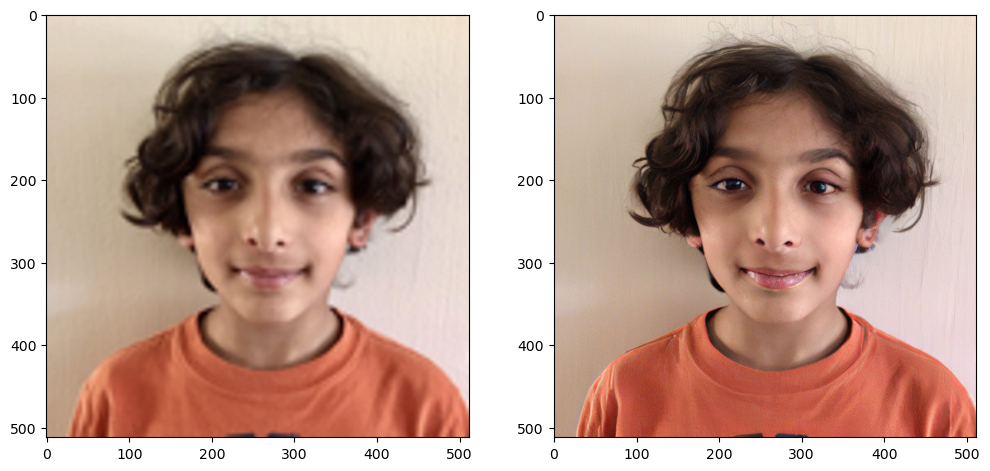

In [34]:
import matplotlib.pyplot as plt
if RASPBERRY_PI:
   low_res_img = down_size_img.resize((96*4, 96*4))
else:    
   low_res_img = down_size_img.resize((128*4, 128*4))
f, axarr = plt.subplots(1,2, figsize=(12, 12))
axarr[0].imshow(low_res_img )
axarr[1].imshow(super_res_image )

In [16]:
param_size = 0
model = pipeline.unet
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 216.718MB
